In [1]:
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow as tf 
from sklearn.preprocessing import StandardScaler
import requests
import json
from tensorflow import keras
import seaborn as sns       


In [2]:
data = pd.read_csv("MicrosoftStock.csv")
print(data.head())
print(data.info())
print(data.describe())

    index        date   open   high    low  close    volume  Name
0  390198  2013-02-08  27.35  27.71  27.31  27.55  33318306  MSFT
1  390199  2013-02-11  27.65  27.92  27.50  27.86  32247549  MSFT
2  390200  2013-02-12  27.88  28.00  27.75  27.88  35990829  MSFT
3  390201  2013-02-13  27.93  28.11  27.88  28.03  41715530  MSFT
4  390202  2013-02-14  27.92  28.06  27.87  28.04  32663174  MSFT
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   1259 non-null   int64  
 1   date    1259 non-null   object 
 2   open    1259 non-null   float64
 3   high    1259 non-null   float64
 4   low     1259 non-null   float64
 5   close   1259 non-null   float64
 6   volume  1259 non-null   int64  
 7   Name    1259 non-null   object 
dtypes: float64(4), int64(2), object(2)
memory usage: 78.8+ KB
None
               index         open         high          low 

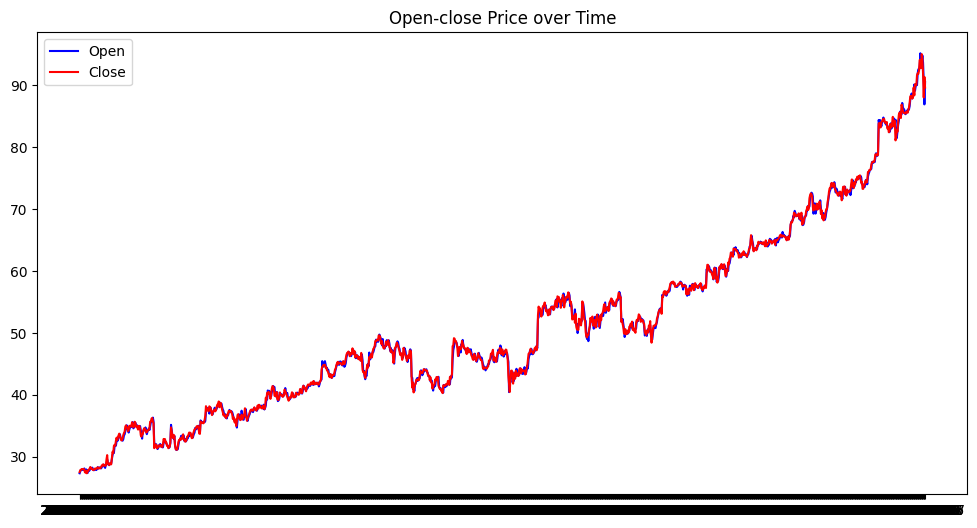

In [3]:
#intial data visualization
#plot 1 - Open and Close prioces of time
plt.figure(figsize=(12,6))
plt.plot(data['date'], data['open'], label="Open", color="blue")
plt.plot(data['date'], data['close'], label="Close", color="red")
plt.title("Open-close Price over Time")
plt.legend()
plt.show()

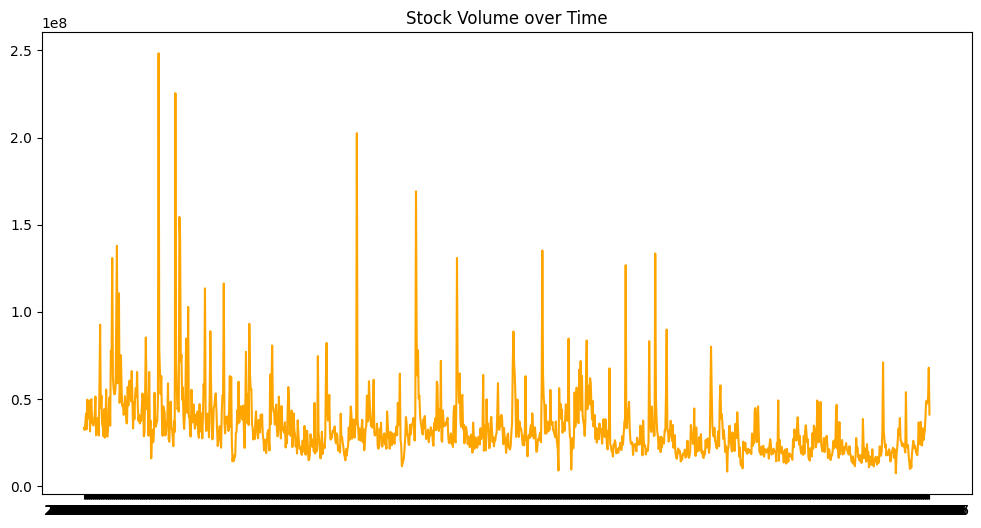

In [4]:
#plot 2- Trading Volume (Chech for outliers)
plt.figure(figsize=(12,6))
plt.plot(data['date'], data['volume'], label="Volume", color= "orange")
plt.title("Stock Volume over Time")
plt.show()

In [5]:
#drop non-numeric columns
numeric_data = data.select_dtypes(include=["int64","float64"])

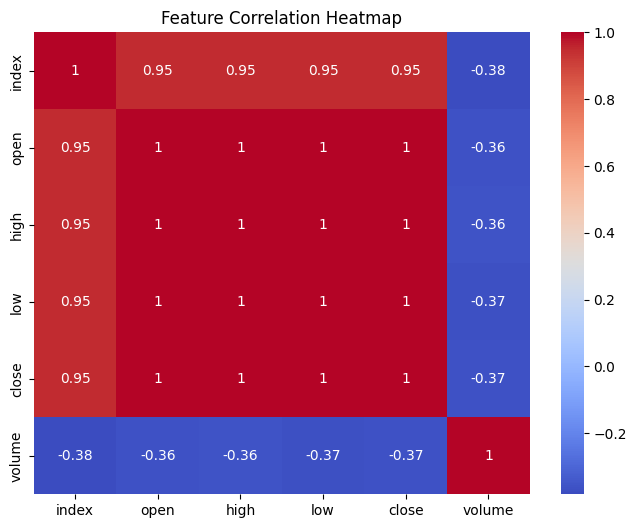

In [6]:
#PLOT 3- Check for corealtion between features
plt.figure(figsize=(8,6))
sns.heatmap(numeric_data.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

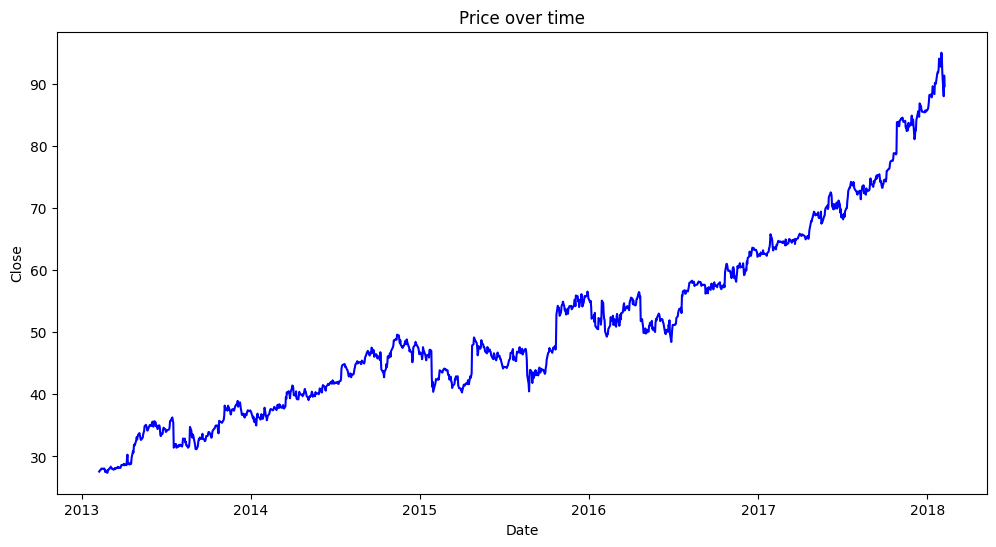

In [7]:
#convert the date into date time and then create a date filter
data['date'] = pd.to_datetime(data['date'])

prediction = data.loc[
    (data['date'] > dt.datetime(2013,1,1,0,0,0)) &
    (data['date'] < dt.datetime(2018,1,1,0,0,0))
    ] 

plt.figure(figsize=(12,6))
plt.plot(data['date'], data['close'], color="blue")
plt.title("Open-close Price over Time")
plt.xlabel("Date")
plt.ylabel("Close")
plt.title("Price over time")
plt.show()

In [8]:
# Prepare for the LSTM Model (Sequential)
stock_close = data.filter(["close"])
dataset = stock_close.values #convert to numpy array
training_data_len = int(np.ceil(len(dataset) * 0.95))


In [9]:
# Preprocessing Stages
scaler = StandardScaler()
scaled_data = scaler.fit_transform(dataset)

training_data = scaled_data[:training_data_len] #95% of all out data

X_train, y_train = [], []


In [10]:
# Create a sliding window for our stock (60 days)
for i in range(60, len(training_data)):
    X_train.append(training_data[i-60:i, 0])
    y_train.append(training_data[i,0])
    
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))


In [11]:
# Build the Model
model = keras.models.Sequential()

# First Layer
model.add(keras.layers.LSTM(64, return_sequences=True, input_shape=(X_train.shape[1],1)))

# Second Layer
model.add(keras.layers.LSTM(64, return_sequences=False))

# 3rd Layer (Dense)
model.add(keras.layers.Dense(128, activation="relu"))

# 4th Layer (Dropout)
model.add(keras.layers.Dropout(0.5))

# Final Output Layer
model.add(keras.layers.Dense(1))

model.summary()
model.compile(optimizer="adam",
              loss="mae",
              metrics=[keras.metrics.RootMeanSquaredError()])


training = model.fit(X_train, y_train, epochs=20, batch_size=32)


C:\Users\meetp\OneDrive\Desktop\files\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 64)              │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 58,369 (228.00 KB)

 Trainable params: 58,369 (228.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.2334 - root_mean_squared_error: 0.3466
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1340 - root_mean_squared_error: 0.1860
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1176 - root_mean_squared_error: 0.1589
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1165 - root_mean_squared_error: 0.1613
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1088 - root_mean_squared_error: 0.1458
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1070 - root_mean_squared_error: 0.1468
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1062 - root_mean_squared_error: 0.1461
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1063 - root_mean_squared_error: 0.1439
Epoch 9/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1074 - root_mean_squared_error: 0.1448
Epoch 10/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1054 - root_mean_squared_error: 0.1424

In [12]:
# Prep the test data
test_data = scaled_data[training_data_len - 60:]
X_test, y_test = [], dataset[training_data_len:]


for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i, 0])
    
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1 ))


In [13]:
# Make a Prediction
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


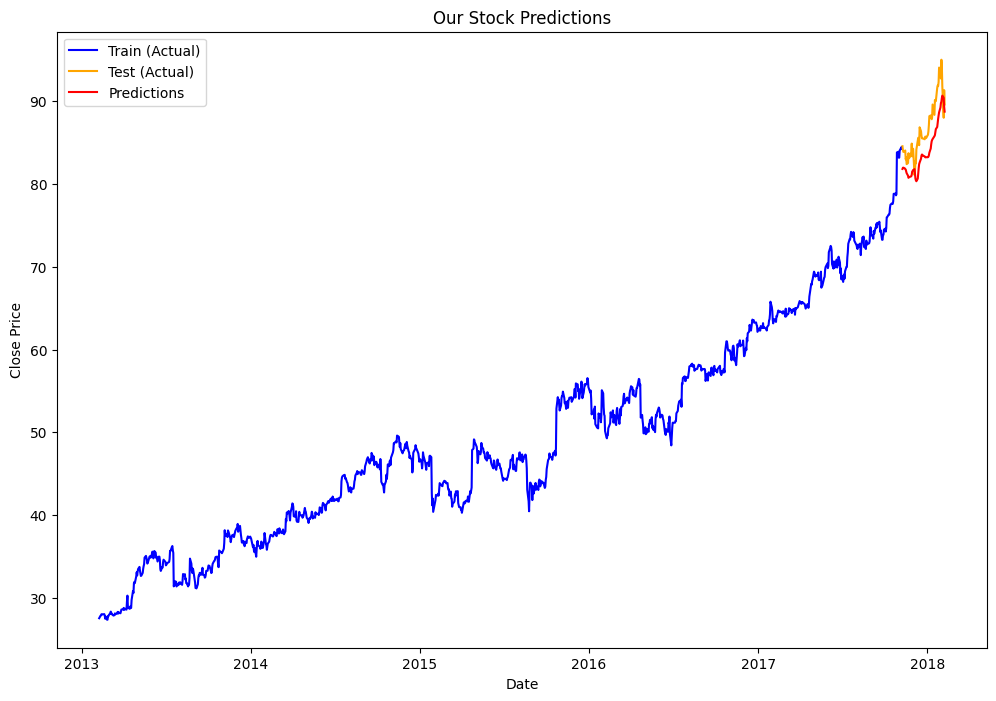

In [14]:

# Plotting data
train = data[:training_data_len]
test =  data[training_data_len:]

test = test.copy()

test['Predictions'] = predictions

plt.figure(figsize=(12,8))
plt.plot(train['date'], train['close'], label="Train (Actual)", color='blue')
plt.plot(test['date'], test['close'], label="Test (Actual)", color='orange')
plt.plot(test['date'], test['Predictions'], label="Predictions", color='red')
plt.title("Our Stock Predictions")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()